# USING AUDITORY DATASETS TO ANALYZE LAND USE PATTERNS

This Jupyter Notebook contains the mainframe code of the project. A brief overview is presented as follows :
1. Data analysis
2. Data preparation
3. Modelling
4. Neural Network Training
5. Evaluation
6. Prediction


This notebook shows how CNN can be used to classify audio files.
Here, a pre-trained VGG-16 network with a custom classifier is applied on spectrograms(log frequency spectrograms)
This gives us a model of which, the accuracy is also calculated


# 1. Data analysis 

This project makes use of audio datasets from recordings made available as part of the DCASE (Detection and Classification of Acoustic Scenes and Events) 2019 challenge: (http://dcase.community/challenge2019/task-acoustic-scene-classification). 

The dataset used in the project is an integral part of DCASE 2019 Challenge (Detection and Classification of Acoustic Scenes and Events). 

1. Broadly, the dataset contains 10 different auditory scene/settings (airport, indoor shopping mall, metro station, pedestrian street, street traffic, tram, bus, metro, park) recorded in 10 cities. 
2. Each audio file is a result of 10 seconds long recording. 
3. Additionally, the data points are in .wav file format

(The dataset can be downloaded from: https://zenodo.org/record/2589280#.YZjyuPFBy3J)

###### from google.colab import drive
###### drive.mount('/content/drive')

In [6]:
import IPython.display as ipd
import librosa, librosa.display
import math
import numpy as np
from collections import OrderedDict
import os
from PIL import Image, ImageDraw, ImageOps
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import statistics
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
import warnings
import wave
import soundfile

In [5]:
rawDataPath = "/Users/livdea/TAU dataset/TAU-urban-acoustic-scenes-2019-development/audio/"

def filenames2dataFrame(path):
    """
    This function collects metadata of audio files used.
    
    path   : directory containing audio files
    return : data frame with metadata
    """
    files = os.listdir(path)
    files = [f for f in files if f.endswith(".wav")]
    data = list()
    for filename in files:
        filepath = os.path.join(path, filename)
        head, tail = os.path.split(filename)
        parts = tail.split('-', 2)
        
        data_sound, samplerate = soundfile.read(filepath)
        soundfile.write(filepath, data_sound, samplerate)
        with wave.open(filepath, "rb") as file:
            sr = file.getframerate()
            duration = file.getnframes() / sr
        data.append( {
            'setting' : parts[0],
            'city' : parts[1],
            'recording' : parts[2],
            'duration' : duration,
            'sr' : sr
        })
    return pd.DataFrame(data)

df = filenames2dataFrame(rawDataPath)

# a major overview on the dataset...

print('Durations are in the range {} - {} s.\n'.format(df['duration'].min(), df['duration'].max()))
print('Sample rates are in the range {} - {} Hz.\n'.format(df['sr'].min(), df['sr'].max()))
print('There are a total of {} recordings.\n'.format(df.shape[0]))
print('Number of recordings per category:\n')
print(df.set_index(['setting', 'city', 'duration', 'sr']).count(level='setting'))
print(df.set_index(['setting', 'city', 'duration', 'sr']).count(level='city'))

Durations are in the range 9.999979166666666 - 10.000020833333334 s.

Sample rates are in the range 48000 - 48000 Hz.

There are a total of 14400 recordings.

Number of recordings per category:

                   recording
setting                     
airport                 1440
bus                     1440
metro                   1440
metro_station           1440
park                    1440
public_square           1440
shopping_mall           1440
street_pedestrian       1440
street_traffic          1440
tram                    1440
           recording
city                
barcelona       1421
helsinki        1447
lisbon          1440
london          1444
lyon            1440
milan           1440
paris           1452
prague          1440
stockholm       1456
vienna          1420


#### At this point, we have got :

* For each setting we have the same number of recordings.
* All recordings are roughly of same duration.
* All recordings use the same sample rate.

In [11]:
# here, we can listen to one audio file for a simple assurance...

sr = 48000

def readAudioFile(filename, sr=48000):
    """Reads an audio file with default sampling rate 48000Hz
    
    filename - file to be read
    return - numpy.float32
    """
    x, sr = librosa.load(filename, sr=sr)
    return x


In [12]:
x = readAudioFile(rawDataPath + 'airport-paris-206-6239-a.wav')
print('number of samples {}'.format(x.shape[0]))
ipd.Audio(x, rate=sr)

number of samples 480000


# 2. Data Preparation

## 2.1. Spectrograms and Mel Spectrograms

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.
(More details are covered in the report)

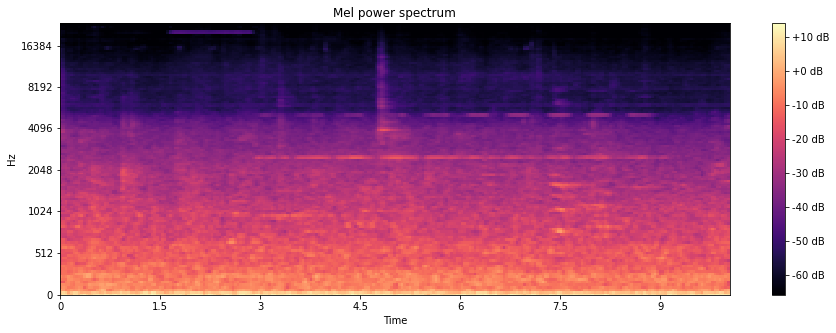

In [13]:
def melSpectrogram(x, sr=48000):
    """
    In this mel spectrogram are drawn.
    
    x  : samples
    sr : sample rate
    """
    
    hop_length = 1875                # this gives us 256 time buckets: 1875 = 10 * 48000 / 256...
    n_fft = 8192                     # this sets the lower frequency cut off to 48000 Hz / 8192 * 2 = 12 Hz...
    S = librosa.feature.melspectrogram(x, sr=sr, n_fft=n_fft, hop_length=hop_length)
    logS = librosa.power_to_db(abs(S))
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(logS, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel power spectrum')
    
melSpectrogram(x)

Ambient sound can contain a lot of low frequency sounds
These are the frequencies that are compressed by the Mel scale.

*So using a logarithmic scale for the the analysis seems more appropriate.*

We create a log-frequency power spectrogram (also referred to as CQT).

## 2.2. Log-frequency spectrograms

In [14]:
def logFrequencySpectrogram(x, sr=48000):

    hop_length = 1024                        # must be a multiple of 2^number_of_octaves...
    n_bins = 256                             # number of bins...
    bins_per_octave = 24                     # a quarter note...
    fmin = 10                                # 10 Hz...
    
    fmax = fmin * math.pow(2., n_bins / bins_per_octave)
    C = librosa.cqt(x, sr=sr, fmin = 10, hop_length=hop_length, n_bins= n_bins,
                    bins_per_octave = bins_per_octave)
    logC = librosa.power_to_db(np.abs(C))
    return logC

def drawLogFrequencySpectrogram(x, sr=48000):
    logC = logFrequencySpectrogram(x, sr)
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='cqt_hz', fmin = 10, bins_per_octave = 24)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q power spectrum')
    plt.show()

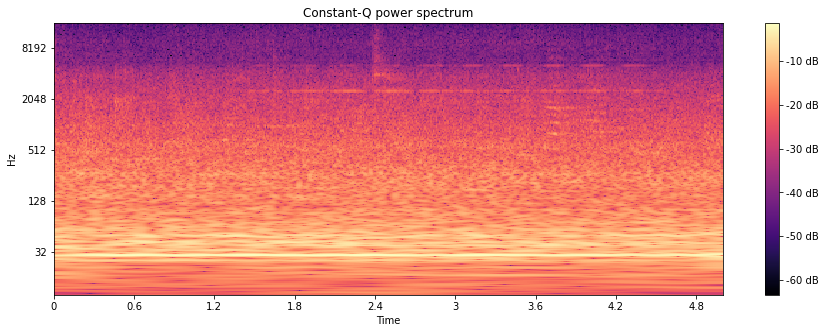

In [15]:
drawLogFrequencySpectrogram(x)

* Now low frequency sounds are clearly visible.
* High frequencies are still not clear.

## 2.3. Pre-emphasis

The high frequencies are emphasized using a filter:

In [16]:
def preEmphasis(x, alpha=.97):
    """
    Algorithmic changes done in this module are also done and
    explained in Conversion_to_spectrograms.py file. There it forms its main mathematical structure.
    
    x     : original signal
    alpha : here, physical constant in terms of designing spectrograms
    """
    return np.append((1 - 2 * alpha) * x[0] + alpha * x[1],
                     x[1:] - alpha * x[:-1]) / (1 - alpha)

p = preEmphasis(x, .97)
ipd.Audio(p, rate=sr)

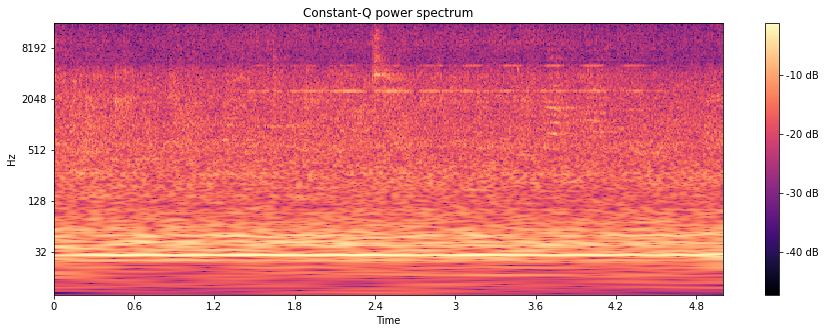

In [17]:
drawLogFrequencySpectrogram(p)

The spectogram can easily be converted to a black and white image. This is the input format that we will use for training the neural network.

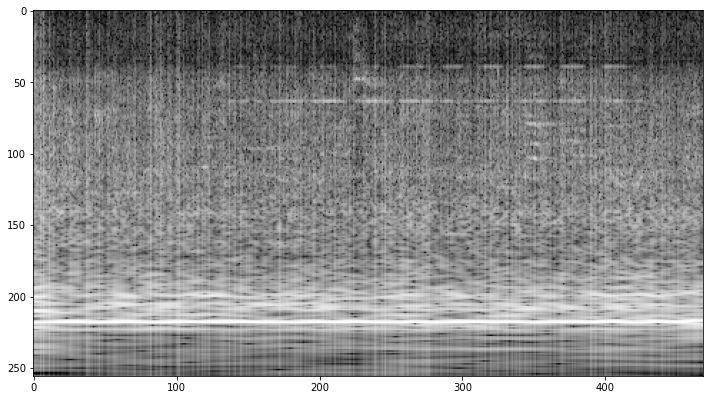

In [18]:
def bwLogFrequencySpectrogram(x, sr=48000):
    """
    Here, in this cell a log-requency spectrogram is created
    as an image. Also, it they are being turned to greyscale. 
    For technical details of the procedure and methodology, 
    project report must be consulted.
    
    x      : input samples continued from last part
    return : output spectrogram
    """
    logC = logFrequencySpectrogram(p);
    scaler = MinMaxScaler(feature_range=(0, 255))
    logC = scaler.fit_transform(logC)
    img = Image.fromarray(logC)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def drawImage(img):
    plt.figure(figsize=(12, 7))
    plt.imshow(img, cmap=plt.cm.gray)
        

drawImage(bwLogFrequencySpectrogram(p))


The file: Conversion_to_spectrograms.py can be used to convert all audio files to spectrograms

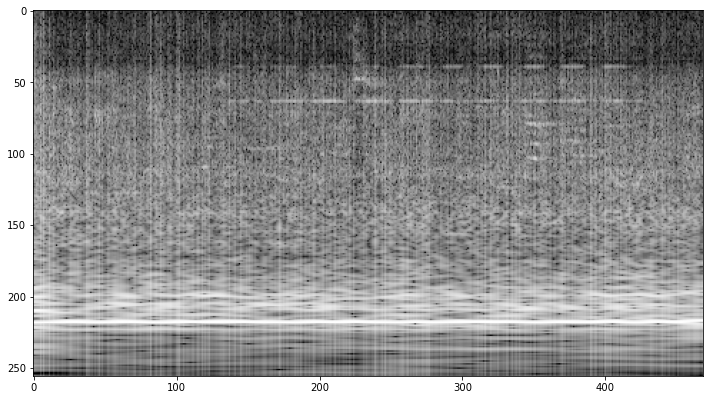

In [19]:
# sample image...

img = Image.open("data/spectrograms/airport/paris/206-6239-a.png")
drawImage(img)

# 3. Modelling

## 3.1. Data augmentation

The number of files per classes are quite small. Therefore to avoid overfitting, data should be augmented.

Some transformations can be applied like:

* frequency masking
* changing the tempo 
* time warping


In [20]:
class RandomAudioTransform:
    """
    Here, a random transformation is done on short time spectrograms.

    The spectrogram is transformed randomly in three ways:

    * The spectrogram frequencies are transposed randomly.
    * The tempo is randomly changed.
    * A random sampling window in time is chosen.
    

    size             : target image size of the spectrogram
    octaves          : number of octaves by which to shift spectrogram
    bins_per_octaves : number of image pixels per octave
    dilation         : maximum relative increment of the tempo
    sample_size      : size of the time window in relation to the whole
                       spectrogram
    random           : True: use random values, False: replace random values by
                       fixed values
    """

    def __init__(self, size=224, octaves=.5, bins_per_octave=24, dilation=0.25,
                 sample_size=.5, random=True):
        """Construct new RandomAudioTransform
        """

        self.size = size
        self.octaves = octaves
        self.bins_per_octave = bins_per_octave
        self.dilation = dilation
        self.sample_size = sample_size
        self.random = random

    def rand(self):
        """
            Generating random numbers in the interval [0., 1.]
        """

        if self.random:
            return random.random()
        return .5

    def __call__(self, img):
        """
        Transforms a spectrogram provided as image.

        img    : input image to transform
        return : transformed image
        """

        # Stretching the time axis according to sample size and time dilation...
        
        width = int((1. + self.dilation * self.rand())
                    * self.size / self.sample_size)
        img = img.resize(size=[width, img.size[1]], resample=Image.BICUBIC)
        
        # Take sample from images...
        
        alpha = self.octaves * self.bins_per_octave / (img.size[0] - self.size)
        center = [self.rand(), (1 - alpha) * .5 + alpha * self.rand()]
        img = ImageOps.fit(img, size=[self.size, self.size],
                           method=Image.BICUBIC, centering=center)
        return img

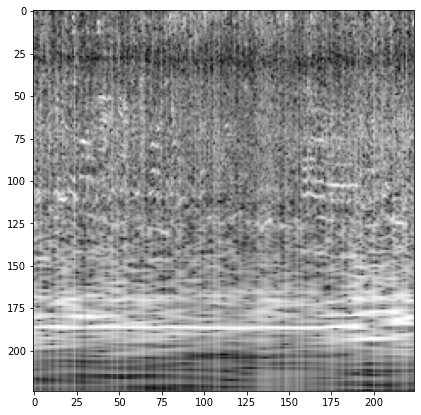

In [21]:
# By default a random 5 second sample of the spectrogram shifted by up to .5 octavs is created.
# This cell can be re-executed to observe random changes.

transform = RandomAudioTransform()
img = Image.open('data/spectrograms/street_pedestrian/lyon/1162-44650-a.png')
drawImage(transform(img))
pass

In [22]:
class FrequencyMask:
    """
    Here, frequency bands are randomly masked in short time spectrograms.

    The spectrogram is transformed randomly in three ways:

    * The spectrogram frequencies are transposed randomly.
    * The speed is randomly changed.
    * A random sampling window in time is chosen.

    max_width  :  maximum portion of all frequencies that will be masked
    """

    def __init__(self, max_width = .2):
        """
            Constructing new FrequencyMask
        """

        self.max_width = max_width

    def __call__(self, img):
        """
        Transforming a spectrogram provided as as image.

        img    : image to transform
        Return : transformed image
        """
        width, height = img.size
        mask_height = height * self.max_width * random.random()
        ymin = math.floor((height - mask_height) * random.random())
        ymax = math.floor(mask_height + ymin)
        draw = ImageDraw.Draw(img)
        draw.rectangle(((0, ymin), (width - 1, ymax)), fill=(127, 127, 127))
        return img

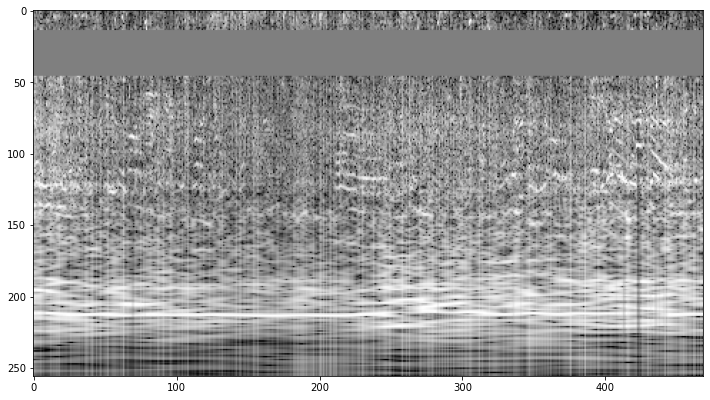

In [23]:
# A random frequency band is masked.
# This cell can be re-executed to observe random changes.

transform = FrequencyMask()
img = Image.open('data/spectrograms/street_pedestrian/lyon/1162-44650-a.png')
drawImage(transform(img))
pass

## 3.2. Train, validation, and test data sets

The data is splitted using: Splitting_datasets.py

# 4. Neural network training

A pre-trained VGG-16 model with custom classifiers is used:

## 4.1. Transforms

In [24]:

def create_transforms(octaves=.5, bins_per_octave=24, dilation=0.25,
                 sample_size=.5, max_width=.2):
    """
    In this cell, the train and test tranforms are created.

    octaves          : number of octaves by which to shift spectrogram
    bins_per_octaves : number of image pixels per octave
    dilation         : maximum relative increment of the tempo
    sample_size      : size of the time window in relation to the whole
                       spectrogram
    max_width        : maximum portion of all frequencies that will be masked
    return           : training and testing/validation transforms
    """

    # This normalization has been used for pre-training the VGG16 model.
    transform_norm = transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    train_transforms = transforms.Compose([RandomAudioTransform(
        octaves=octaves, bins_per_octave=bins_per_octave, dilation=dilation,
        sample_size=sample_size, random=True),
                                           FrequencyMask(max_width),
                                           transforms.ToTensor(),
                                           transform_norm])

    test_transforms = transforms.Compose([RandomAudioTransform(
        random=False),
                                          transforms.ToTensor(),
                                          transform_norm])

    return train_transforms, test_transforms
    


## 4.2. Data loaders

In [25]:
data_dir = '/content/drive/MyDrive/AI_Project_MAnTHan/splitted/'

def create_data_loaders(train_transforms, test_transforms, data_dir):
    """
    Data loaders | self explanatory 
    
    data_dir         : directory with data
    train_transforms : transforms for training
    test_transforms  : transforms for validation and testing
    """
    
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')
    valid_dir = os.path.join(data_dir, 'valid')

    train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
    valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
    test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

    class_to_idx = test_data.class_to_idx

    
    train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=True)
    
    return train_loader, test_loader, valid_loader, class_to_idx

## 4.3 Model

In [26]:
def get_in_features(model):
    """
        Gets the number of in_features of the classifier.
    """
    in_features = 0
    for module in model.classifier.modules():
        try:
            in_features = module.in_features
            break
        except AttributeError:
            pass
    return in_features

def create_classifier(model, out_features, hidden_units=512):
    """
        Creates the classifier
    """
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(get_in_features(model), hidden_units)),
        ('relu1', nn.ReLU(inplace=True)),
        ('drop1', nn.Dropout(.5)),
        ('fc2', nn.Linear(hidden_units, hidden_units)),
        ('relu2', nn.ReLU(inplace=True)),
        ('drop2', nn.Dropout(.5)),
        ('fc3', nn.Linear(hidden_units, out_features)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    model.classifier = classifier


In [27]:
def load_model(out_features, hidden_units, classifier_only = True):
    """
    Loads the pretrained model
    
    out_features    : number of features to predict
    classifier_only : change classifier parameters only
    """
    
    method_to_call = getattr(models, 'vgg16')
    model = method_to_call(pretrained=True)

    if classifier_only:
        # Do not update model parameters
        for param in model.parameters():
            param.requires_grad = False

    # Add our own classifier
    create_classifier(model, out_features=out_features,
                      hidden_units=hidden_units)
    
    return model


In [28]:
def check_accuracy(model, test_loader, device='cuda', mute=True, print_every=40):
    """
        Checks the accuracy of the model.
    """
    correct = 0
    total = 0
    steps = 0
    expected = []
    actual = []

    model.to(device)
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            for label in labels.tolist():
                expected.append(label)
            for prediction in predicted.tolist():
                actual.append(prediction)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if not mute:
                print('-', end='', flush=True)
                if steps % print_every == 0:
                    print()
    accuracy = 100 * correct / total    
    if not mute:
        print('\nAccuracy: {:.4f} %'.format(accuracy))
        print('Confusion matrix')
        print(confusion_matrix(expected, actual))
    return accuracy

In [29]:
def save_checkpoint(path, model, optimizer, class_to_idx):
    """
        Save a checkpoint
    """
    model.class_to_idx = class_to_idx
    warnings.filterwarnings("ignore", category=UserWarning)
    torch.save({'model': model,
                'optimizer': optimizer}, path)
    warnings.filterwarnings("default", category=UserWarning)

In [30]:
def do_deep_learning(model, criterion, optimizer, train_loader, valid_loader,
                     class_to_idx, epochs=1, device='cuda', print_every=40,
                     mute=True):
    """
    Executes the training steps
        MAIN TASK : Training is discontinued if there is no improvement for 10 epochs.
    """

    model.to(device)
    model.train()
    
    best_accuracy = 0.0
    worse_count = 0
    
    for epoch in range(epochs):
        running_loss = 0
        steps = 0
        for inputs, labels in train_loader:
            steps += 1

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if not mute:
                running_loss += loss.item()
                print('.', end='', flush=True)
                if steps % print_every == 0:
                    print("Epoch: {}/{}, ".format(epoch + 1, epochs),
                          "Loss: {:.4f}".format(running_loss/print_every))
                running_loss = 0

        if not mute:
            while steps % print_every != 0:
                print(' ', end='')
                steps += 1
            print("Epoch {} completed".format(epoch + 1))
        accuracy = check_accuracy(model, valid_loader, mute=mute)
        if mute:
            print("*", end='')
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            worse_count = 0
            
            # To avoid disk wear the checkpoint is saved in the
            # /tmp directory which hopefully is a RAM disk.
            
            save_checkpoint('/content/drive/MyDrive/AI_Project_MAnTHan/Weights/checkpoint.pt', model, optimizer, class_to_idx)
        else:
            worse_count += 1
            if worse_count == 10:
                if not mute:
                    print("No improvement for 10 epochs")
                break

    print()
    return best_accuracy

In [ ]:
def run_training(octaves=.5, bins_per_octave=24, dilation=0.25,
                 sample_size=.5, max_width = .2,
                 hidden_units=512, epochs=200, mute=True):
    """ 
    Runs training for given hyper parameters

    octaves          : number of octaves by which to shift spectrogram
    bins_per_octaves : number of image pixels per octave
    dilation         : maximum relative increment of the tempo
    sample_size      : size of the time window in relation to the whole
                       spectrogram
    max_width        : maximum portion of all frequencies that will be masked
    return           : training and testing/validation transforms
    """
    
    train_transforms, test_transforms = \
        create_transforms(octaves=octaves, bins_per_octave=bins_per_octave, dilation=dilation,
                          sample_size=sample_size, max_width = max_width)
    train_loader, test_loader, valid_loader, class_to_idx = \
        create_data_loaders(train_transforms, test_transforms, data_dir='/content/drive/MyDrive/AI_Project_MAnTHan/splitted/')
    model = load_model(len(class_to_idx), hidden_units)
        
    optimizer = optim.Adam(model.classifier.parameters(), lr=.001)
    criterion = nn.NLLLoss()
    accuracy = do_deep_learning(model, criterion, optimizer, epochs=epochs,
                                train_loader=train_loader, valid_loader=valid_loader,
                                class_to_idx=class_to_idx, mute=mute)
    
    return accuracy, model, test_loader, test_transforms, class_to_idx

# To make this reproducible let'use fixed random seeds
torch.manual_seed(8259)
random.seed(6745)
accuracy, model, test_loader, test_transforms, class_to_idx = run_training(epochs=200,mute=False)
print('Achieved accuracy: {}'.format(accuracy))

........................................Epoch: 1/200,  Loss: 0.0534
........................................Epoch: 1/200,  Loss: 0.0461
........................................Epoch: 1/200,  Loss: 0.0411
........................................Epoch: 1/200,  Loss: 0.0406
........................................Epoch: 1/200,  Loss: 0.0458
........................................Epoch: 1/200,  Loss: 0.0397
.................................       Epoch 1 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 49.5327 %
Confusion matrix
[[ 84   1  10   2   9   1 118  66   0   0]
 [  0 262   3   0   2   0   1   0   1  21]
 [  2  56  80  17  15   1  14   5   3  98]
 [ 11  24  49  31  23   2  73  23  24  30]
 [  0   0   5   0 241  10   1   9  13  11]
 [ 12   5   7   4  44  33  44  86  52   3]
 [ 28   5   3   8   0   0 194  37   2   1]
 [ 25   3   8   3  18  17  69 121  24   1]
 [  1   7   2   3  41   7   2  15 211   1]
 [  0  64  14   

# 5. Evaluation

The model is saved as file: checkpoint.pt in the Weights folder.

In [31]:
def load_checkpoint(path='checkpoint.pt'):
    """
        Reloads model from checkpoint
    """
    checkpoint = torch.load(path)
    model = checkpoint['model']
    return model

In [ ]:
# Check the accuracy using the test data

model = load_checkpoint('/content/drive/MyDrive/AI_Project_MAnTHan/Weights/checkpoint.pt')
class_to_idx = model.class_to_idx
check_accuracy(model, test_loader, mute=False)
pass

----------------------------------------
----------------------------------------
-----------
Accuracy: 67.6410 %
Confusion matrix
[[198   0   4   5   1   8  49  22   2   1]
 [  1 261  14   3   0   1   0   0   2   8]
 [  7  13 208  26   1   2   9   1   2  20]
 [ 25   8  29 143   9   9  39  12   6  10]
 [  3   0   0   3 252  21   0   3   7   1]
 [ 28   0   3   7  24 135  23  45  34   1]
 [ 25   0   2  11   1   3 228  20   0   0]
 [ 30   0   1   8   8  34  34 166   8   0]
 [  1   1   0   5  23  19   2   7 232   0]
 [  2  16  90  18   9   1   3   6   1 144]]


In [ ]:
class_to_idx

{'airport': 0,
 'bus': 1,
 'metro': 2,
 'metro_station': 3,
 'park': 4,
 'public_square': 5,
 'shopping_mall': 6,
 'street_pedestrian': 7,
 'street_traffic': 8,
 'tram': 9}

# 6. Prediction


In [32]:
class Predict:
    """
        Image classifier
    """

    def __init__(self):
        """
            Constructor
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.image = None
        self.category_names = None
        self.top_k = 5

    def classify(self, image_file_name, checkpoint_file_name,
                 category_names_file_name = None):
        """
            Classifies an image
        """
        self.load_checkpoint(checkpoint_file_name)
        self.load_image(image_file_name)
        if category_names_file_name is not None:
            self.load_category_names(category_names_file_name)
        probs, categories = self.infer(self.top_k)
        self.output(probs, categories)
        self.draw_prediction(probs, categories)

    def infer(self, top_k):
        """
            Infers the classes
        """
        self.model.to(self.device)
        self.model.eval()
        inputs = torch.stack((self.image,))
        inputs = inputs.to(self.device)

        with torch.no_grad():
            outputs = self.model(inputs)

        outputs = outputs.to("cpu")
        probs, indices = outputs.topk(top_k)
        probs = probs.exp()
        probs = probs.tolist()[0]
        indices = indices.tolist()[0]
        categories = [self.idx_to_class[index] for index in indices]
        return probs, categories

    def load_checkpoint(self, checkpoint_file_name):
        """
            Loads checkpoint from file
        """
        checkpoint = torch.load(checkpoint_file_name, map_location={'cuda:0': 'cpu'})
        self.model = checkpoint['model']
        self.criterion = nn.NLLLoss()
        class_to_idx = self.model.class_to_idx
        self.idx_to_class = {value : key
                             for key, value in class_to_idx.items()}

    def load_image(self, image_file_name):
        """
            Loads image from file
        """
        self.image = Image.open(image_file_name).convert('RGB')
        self.image = self.normalize_image(self.image)

    def normalize_image(self, image):
        """
            Normalizes image
        """
        return test_transforms(image)

    def output(self, probs, categories):
        """
            Outputs category names and propabilities
        """
        if self.category_names is not None:
            categories = [self.category_names[category]
                          for category in categories]
            category_title = 'Category Name'
        else:
            category_title = 'Category'
        max_len = max([len(category) for category in categories])
        max_len = max(max_len, len(category_title))
        print('{:>{}} | {}'.format(category_title, max_len, 'Probability'))
        print('{:>{}}-+-{}'.format('-' * max_len, max_len, '-----------'))
        for i in range(len(probs)):
            print('{:>{}} | {:.4f}'.format( categories[i], max_len, probs[i]))

    def draw_prediction(self, propabilities, categories,
                        true_category = '', title = 'Prediction'):
        
        """
            Draws a plot showing the prediction
        """

        fig, plot = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
        fig.tight_layout()
        fig.suptitle(title, fontsize=20, y=1.05)

        margin = 0.05
        n_cat = len(categories)
        ind = np.arange(n_cat)
        width = (1. - 2. * margin) / n_cat
    
        plot.barh(ind, propabilities[::-1], height = .8)
        plot.set_yticks(ind + margin)
        plot.set_yticklabels(categories[::-1], fontsize=16)
        plot.set_xlabel('probability')
            
    def set_device(self, device_name):
        """
            Sets the cuda device
        """
        self.device = torch.device(device_name)

    def set_top_k(self, top_k):
        """
            Set number of categories to output
        """
        self.top_k = top_k
        

In [33]:
# Can you identify the sound?

x = readAudioFile(rawDataPath + 'airport-paris-206-6239-a.wav')
ipd.Audio(x, rate=sr)

In [34]:
octaves = .5 
bins_per_octave=24
dilation=0.25 
sample_size=.5
max_width = .2
train_transforms, test_transforms = \
        create_transforms(octaves=octaves, bins_per_octave=bins_per_octave, dilation=dilation,
                          sample_size=sample_size, max_width = max_width)

         Category | Probability
------------------+------------
          airport | 0.3411
    shopping_mall | 0.1895
street_pedestrian | 0.1711
    metro_station | 0.1451
    public_square | 0.1191


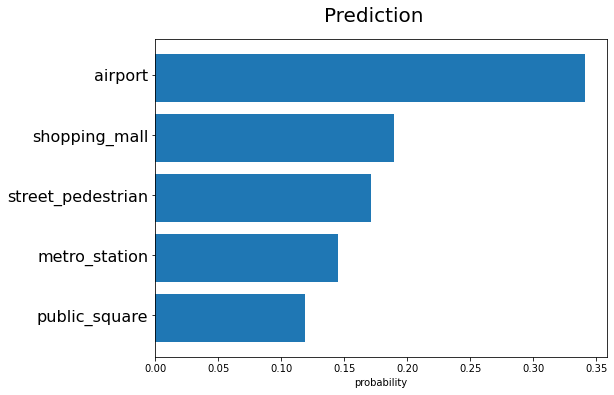

In [35]:
# Check your guess against the prediction.

predict = Predict()
predict.classify('data/splitted/test/airport/paris/206-6239-a.png', 'Weights/checkpoint.pt', None)